# Analysis Notebook – Rigidification analysis of Ab lineages

**Author:** Matteo Cagiada  

**Date:** November, 2025 

**Version:** v1.0

**Contact email:** matteo.cagiada@bio.ku.dk / matteo.cagiada@stats.ku.dk

---

## Overview

This Jupyter notebook accompanies the paper:

> **Uncovering the flexibility of CDR loops in antibodies and TCRs through large-scale molecular dynamics**  
> Matteo Cagiada, Fabian C. Spoendlin, King Ifashe, Charlotte M. Deane
> biorxiv - 2025

---

## How to Run

To run this notebook simply clone the github repository and run it. Necessary files are already allocated in the right folders.
The antibodies lineages included in this notebook are collected from: "Local and global rigidification upon antibody affinity maturation - Fernández-Quintero M.,et. al. - FMB (2020)"

### Requirements
- **Python version:** 3.9+  
- **Environment:** Conda
- **Dependencies:** numpy, MDanalysis, pandas, matplotlib

In [1]:
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis import Merge

/Users/bqm193/miniconda3/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def calc_rmsd(u,uref,select='all',f_out=None,step=1):
    # print('First alignment')
    aligner = align.AlignTraj(u, uref, select=select, in_memory=True).run(step=step) # align to crystal structure
    Rref = rms.RMSD(u,uref,select=select) # get RMSD to reference
    Rref.run(step=step)
    coords = u.trajectory.timeseries(u.atoms,step=step) 
    coords_mean = coords.mean(axis=1) # get mean structure
    u_mean = Merge(u.atoms) # new universe from mean structure
    u_mean.load_new(coords_mean[:, None, :], order="afc")

    # print('Second alignment')
    aligner = align.AlignTraj(u, u_mean, select=select, in_memory=True).run(step=step) # align to mean structure
    coords = u.trajectory.timeseries(u.atoms,step=step) # get coords
    coords_mean = coords.mean(axis=1) # get new mean
    u_mean2 = Merge(u.atoms)
    u_mean2.load_new(coords_mean[:, None, :], order="afc")
    
    Rmean = rms.RMSD(u,u_mean2,select=select) # get RMSD to new mean structure
    Rmean.run(step=step)
    
    return Rref.results.rmsd.T,Rmean.results.rmsd.T

In [3]:
def extract_cdr_coord(dict_loc,chain,cdr_boundaries):
    with open(dict_loc,'r') as f:
        img_cv3_map=json.load(f)
    return [img_cv3_map[chain][str(elem)+'.0'] for elem in cdr_boundaries]

In [4]:
cdrs_list=[[27,38],[56,65],[105,117]]

## Analysis

In [5]:
#s25 no pdb processed from us
data_df={'D44.1/F10.6.6':('1mlb_BA','2q76_DC'),
         '28b4':('1fl6_HL','1kel_HL'),
         '48G7':('1aj7_HL','1hkl_HL'),
         'az-28':('1d6v_HL','1axs_BA'),
         'aDabiFab':('4yhi_AB','4yho_HL'),
         'Anti-MPTS':('4nja_HL','4nj9_HL'),
         '4-4-20':('1t66_DC','4fab_HL'),
         '7G12':('1n7m_LH','1ngw_BA')
        }

In [6]:
rmsd_distr={}
rmsd_medians={}

In [9]:
for sys in data_df.keys():
    rmsd_distr[sys]={}
    rmsd_medians[sys]={}
    paired_pdb=data_df[sys]
    for pdb in paired_pdb:
        
        sel_chain=pdb[-2:]

        dict_imgt2cv=f'../src/quintero_FMB_2020/{pdb}/{pdb[:4]}_dict_Fv_{pdb[-2:]}.txt'
        
        prefix_sim=os.path.abspath(f'../src/quintero_FMB_2020/{pdb}/{pdb[:4]}_Fv_{pdb[-2:]}')
        topology_fa= os.path.join(prefix_sim+"_top.pdb")
        
        xtc_file = os.path.join(prefix_sim+"_aligned.xtc")
        
        
        mobile = mda.Universe(topology_fa,xtc_file)
        ref = mda.Universe(topology_fa,xtc_file)
        
        mobile.trajectory  # set mobile trajectory to last frame
        ref.trajectory[0]  # set reference trajectory to first frame
        ##dict_loc,chain,cdr_boundaries
        cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]
        cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

        _,Rmean_cdr3=calc_rmsd(mobile,ref,select=f"name CA and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}",f_out=None,step=1)

        rmsd_distr[sys][pdb]=Rmean_cdr3[2,250:]
        rmsd_medians[sys][pdb]=np.median(Rmean_cdr3[2,250:])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(
Exception ignored in: <function ReaderBase.__del__ at 0x147223d90>
Traceback (most recent call last):
  File "/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py", line 1532, in __del__
    self.close()
  File "/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py", line 186, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


Mean RMSD decreased by 19.32%
Mean RMSD decreased by 4.68%
Mean RMSD decreased by 14.57%
Mean RMSD decreased by 14.18%
Mean RMSD decreased by -4.08%
Mean RMSD decreased by 0.21%
Mean RMSD decreased by 16.47%
Mean RMSD decreased by 7.57%


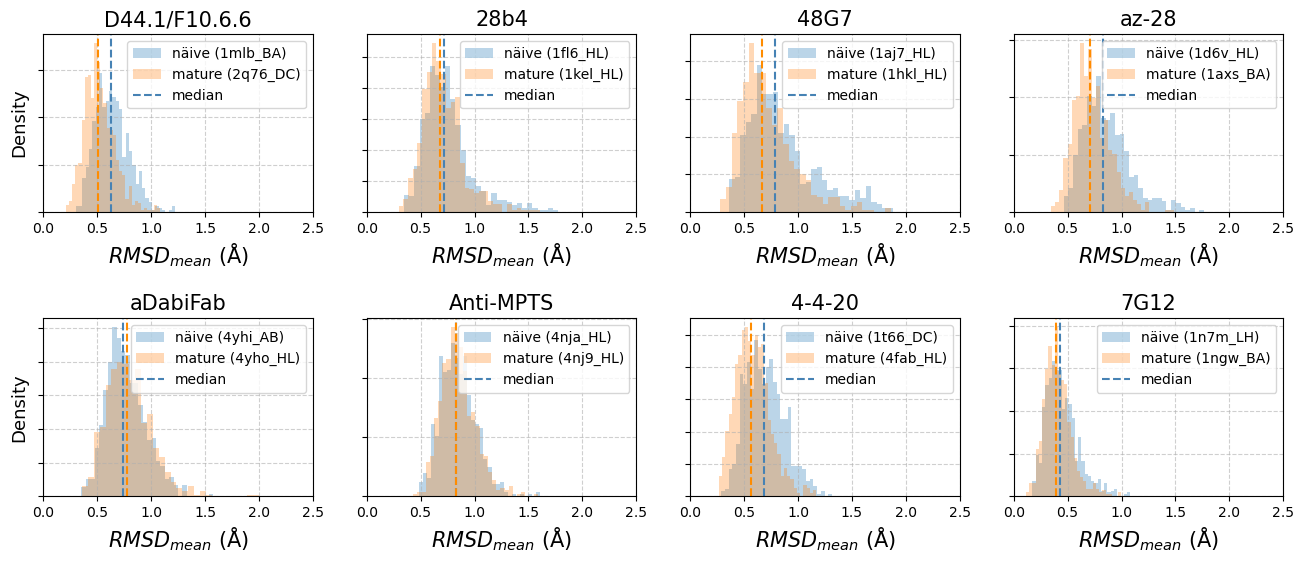

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(16, 6),gridspec_kw={'hspace': 0.6, 'wspace': 0.2})
axs=axs.flatten()
for idx,sys in enumerate(data_df.keys()):
    # --- First subplot ---
    axs[idx].hist(rmsd_distr[sys][data_df[sys][0]], bins=30, alpha=0.3, label=f'näive ({data_df[sys][0]})', density=True)
    axs[idx].hist(rmsd_distr[sys][data_df[sys][1]], bins=30, alpha=0.3, label=f'mature ({data_df[sys][1]})', density=True)
    
    # Add mean lines
    axs[idx].axvline(rmsd_medians[sys][data_df[sys][0]], color='steelblue', linestyle='--', linewidth=1.5,label='median')
    axs[idx].axvline(rmsd_medians[sys][data_df[sys][1]], color='darkorange', linestyle='--', linewidth=1.5)
    
    axs[idx].set_xlabel(r'$RMSD_{mean}$ (Å)',fontsize=15)
    #axs[idx].set_ylabel('Density')
    axs[idx].set_title(sys,fontsize=15)
    axs[idx].set_yticklabels([])
    axs[idx].grid(True, linestyle='--', alpha=0.6)
    axs[idx].legend()
    axs[idx].set_xlim(0,2.5)
    
    percent_decrease = (rmsd_medians[sys][data_df[sys][0]] -rmsd_medians[sys][data_df[sys][1]]) / rmsd_medians[sys][data_df[sys][0]] * 100
    print(f"Mean RMSD decreased by {percent_decrease:.2f}%")

axs[0].set_ylabel('Density',fontsize=13)
axs[4].set_ylabel('Density',fontsize=13)

plt.savefig('../figures/quintero_comparison_mature.pdf')